In [1]:
import os

import pandas as pd

In [2]:
DATA_DIR = os.path.join(os.pardir, os.pardir, "data", "marketing-bancaire")

In [3]:
data = pd.read_csv(
    os.path.join(DATA_DIR, "data.csv"),
    encoding="latin-1",
    sep=";",
).drop(columns="Unnamed: 0")
socio_eco = pd.read_csv(
    os.path.join(DATA_DIR, "socio_eco.csv"),
    sep=";",
    na_values="???",
).drop(columns="Unnamed: 0")

Gestion des types

In [4]:
data['date'] = pd.to_datetime(data['date']).dt.to_period('M')
socio_eco['date'] = pd.to_datetime(socio_eco['date'], dayfirst=True).dt.to_period('M')

Gestion des valeurs manquantes de socio_eco

In [5]:
socio_eco[['idx_prix_conso', 'idx_conf_conso']] = socio_eco[['idx_prix_conso', 'idx_conf_conso']].ffill()

socio_eco['trimestre'] = socio_eco['date'].dt.quarter
# on va utiliser la dernière valeur non nulle par trimestre
socio_eco['tx_var_emploi'] = socio_eco.groupby('trimestre')['tx_var_emploi'].transform(lambda x: x.ffill().bfill())
# suppression de la colonne créée temporairement
socio_eco = socio_eco.drop(columns='trimestre')

Nettoyage de data

In [6]:
data["job"] = data["job"].str.strip()

Jointure

In [7]:
df = pd.merge(data, socio_eco, on='date', how='left')

Prétraitrement (dont fin de la gestion des valeurs manquantes), avec un formalisme de pipeline

Split

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["statut", "duree_contact"])
y = df["statut"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [9]:
X_train.shape

(36108, 17)

In [10]:
X_test.shape

(9028, 17)

In [11]:
len(y_test)

9028

Preprocessor

In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_cols = X.select_dtypes(include=["number"]).columns
num_imputer = SimpleImputer(strategy="median")

cat_cols = X.select_dtypes(include=["object"]).columns
cat_imputer = SimpleImputer(strategy="most_frequent")

ohe_encoder = OneHotEncoder(handle_unknown="ignore")

by_col_preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            num_imputer,
            num_cols,
        ),
        (
            "cat",
            Pipeline(steps=[
                ("imputer", cat_imputer),
                ("encoder", ohe_encoder),
            ]),
            cat_cols,
        ),
    ]
)


Autres étapes du pipeline

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

std_scaler = StandardScaler()
rf_model = RandomForestClassifier(random_state=9)

global_pipeline = Pipeline(
    steps=[
        ("by col preprocessing", by_col_preprocessor),
        ("scaling", std_scaler),
        ("model", rf_model),
    ]
)

Entraînement du modèle (en vrai entraînement de mon pipeline global)

In [31]:
global_pipeline.fit(X_train, y_train)

Pipeline(steps=[('by col preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['age', 'balance', 'nb_contact', 'nb_j_dernier_contact',
       'nb_contact_derniere_campagne', 'tx_var_emploi', 'idx_prix_conso',
       'idx_conf_conso'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['job', 'relation', 'education', 'defaut', 'pret_immo', 'pret_perso',
       'contact', 'resultat_derniere_campagne'],
      dtype='object'))])),
                ('scaling', StandardScaler()),
                ('model', RandomForestClassifier(random_state=9))])

Predictions

In [32]:
y_pred = global_pipeline.predict(X_test)

Rapport de classification

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Absent       0.37      0.34      0.36      3175
  En Attente       0.00      0.00      0.00       153
       Refus       0.47      0.59      0.52      3956
    Souscrit       0.49      0.40      0.44      1100
 Suppression       0.11      0.03      0.04       644

    accuracy                           0.43      9028
   macro avg       0.29      0.27      0.27      9028
weighted avg       0.40      0.43      0.41      9028



Feature importance

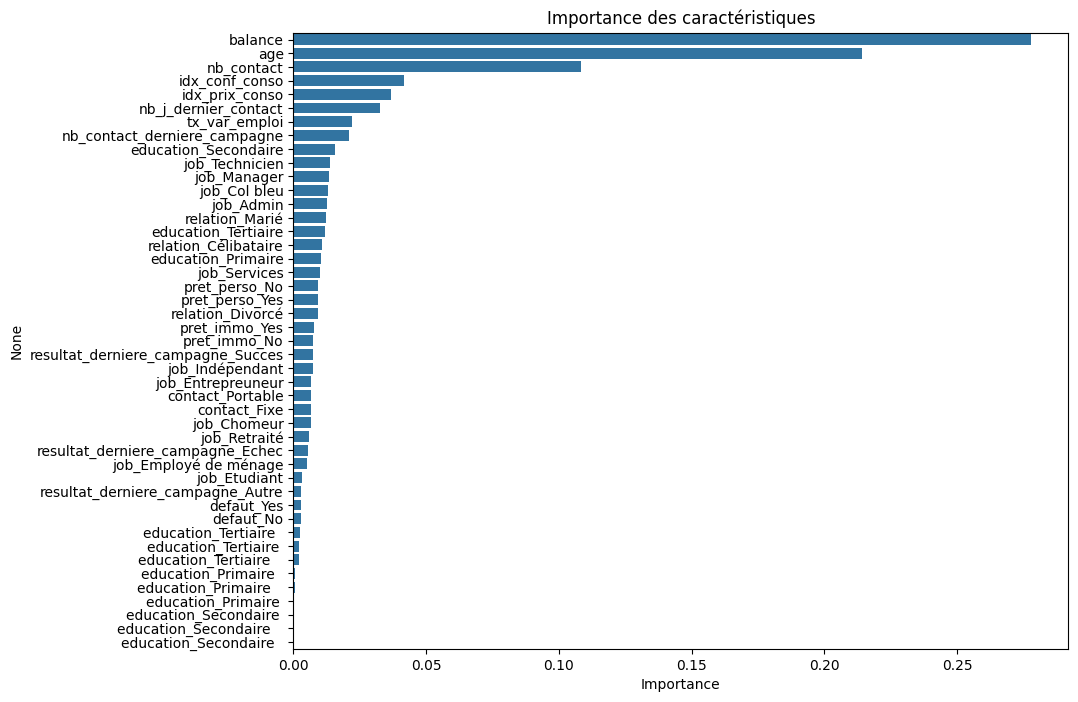

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = global_pipeline.named_steps['model'].feature_importances_
feature_names = global_pipeline.named_steps['by col preprocessing'].transformers_[1][1]['encoder'].get_feature_names_out(cat_cols).tolist()
feature_names = num_cols.tolist() + feature_names

# Affichage de l'importance des caractéristiques
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title("Importance des caractéristiques")
plt.show()

Vos remarques

<i>A compléter</i>